In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

from spykshrk.realtime.simulator import nspike_data

from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPDecoder
from spykshrk.franklab.pp_decoder.data_containers import EncodeSettings, DecodeSettings, SpikeObservation, \
                                                         LinearPosition, StimLockout, Posteriors

%load_ext Cython

%matplotlib inline

#pd.set_option('float_format', '{:,.2f}'.format)
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
#pd.set_option('display.width', 180)

idx = pd.IndexSlice


In [2]:
# Load config file and data

config_file = '/home/daliu/Src/spykshrk_realtime/config/bond_single.json'
config = json.load(open(config_file, 'r'))

# Main hdf5 data source file name
hdf_file = os.path.join(config['files']['output_dir'],
                        '{}.rec_merged.h5'.format(config['files']['prefix']))

# Extract just encode and decode settings from config
encode_settings = EncodeSettings(config)
decode_settings = DecodeSettings(config)

# Open data file
store = pd.HDFStore(hdf_file, mode='r')

# Encapsulate Spike Observation panda table in container
observ_obj = SpikeObservation.create_from_realtime(store['rec_3'])

# Grab stimulation lockout times
stim_lockout = StimLockout.create_from_realtime(store['rec_11'])

# Grab animal linearized real position
nspike_anim = nspike_data.AnimalInfo(**config['simulator']['nspike_animal_info'])
pos = nspike_data.PosMatDataStream(nspike_anim)
pos_data = pos.data

# Encapsulate linear position
lin_obj = LinearPosition.create_from_nspike_posmat(pos_data, encode_settings)

In [3]:
# Linearized position data, example of MultiIndexing pandas table
lin_obj

<LinearPosition: dbcd2e01-969d-426d-b33d-74622e9efdc5, shape: ((28290, 7))>

In [4]:
# Up sampling position data to 30 samples/bin, using backfill to interpolate
lin_obj.get_resampled(30)

<LinearPosition: 31a12c6c-83b4-4f86-a67c-3a74bf04e352, shape: ((943968, 8))>

In [5]:
# Down sampling position data to 30000 samples/bin, dropping data points
lin_obj.get_resampled(30000)

<LinearPosition: e1a7b011-9dc8-4e6d-8d27-a2478b5c285c, shape: ((943, 8))>

In [6]:
# Observation distribution of each spike in a single epoch. This is calculated and cached from 
# an encoding model in the realtime module. Currently this is only valid for a single epoch's data.

observ_obj

,,ntrode_id,position,rec_ind,x000,x001,x002,x003,...,x443,x444,x445,x446,x447,x448,x449
timestamp,time,,,,,,,,,,,,,,,
73830048,"2,461.0",29.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73830066,"2,461.0",13.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73830144,"2,461.0",14.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73830192,"2,461.0",14.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73830204,"2,461.0",13.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102149649,"3,405.0",11.0,7.6,"237,333.0",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102149697,"3,405.0",12.0,7.6,"55,281.0",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102149817,"3,405.0",17.0,7.6,"96,729.0",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Assign bins (300 samples == 10ms) to each spike based on its timestamp, bins stored as dec_bin column.

observ_obj.update_observations_bins(300)

,,ntrode_id,position,rec_ind,x000,x001,x002,x003,...,x444,x445,x446,x447,x448,x449,dec_bin_start
timestamp,dec_bin,,,,,,,,,,,,,,,
73830048,0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,73830000
73830066,0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,73830000
73830144,0,14.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,73830000
73830192,0,14.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,73830000
73830204,0,13.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,73830000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102149649,94398,11.0,7.6,"237,333.0",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,102149400
102149697,94398,12.0,7.6,"55,281.0",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,102149400
102149817,94399,17.0,7.6,"96,729.0",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,102149700


In [8]:
# For each time bin, compute the product of the distribution stored in columns x0:x449.
# This estimates the probability distribution of position at each time bin. Refer to 
# spykshrk.franklab.pp_decoder.pp_clusterless.OfflinePPDecoder.calc_observation_intensity
# for analysis code that uses groupby.

spike_decode = observ_obj.update_observations_bins(3000)
groups = spike_decode.groupby('dec_bin')

def prod_dist(df):
    norm_prod = np.ones(450)
    for row in df.loc[:,'x000':'x449'].values:
        norm_prod = norm_prod * row
        norm_prod = norm_prod / norm_prod.sum()
    prod_ser = pd.Series(norm_prod, index=['x{:03d}'.format(bin_id) for bin_id in range(450)])
    prod_ser['timestamp'] = df['dec_bin_start'].iloc[0]
    return prod_ser

observ_binned = groups.apply(prod_dist)

post = Posteriors(observ_binned, history=spike_decode.history)

In [9]:
# Convert linearized position segments onto a single axis to match the decoded position mapping.
# This function uses the query command of Panda dataframes.
# e.g.:
# right_pos_flat = (self.pos_data.query('@self.pos_data.seg_idx.seg_idx == 4 | '
#                                       '@self.pos_data.seg_idx.seg_idx == 5').
#                   loc[:, ('lin_dist_well', 'well_right')]) + self.arm_coord[2][0]

single_axis_lin_pos = lin_obj.get_resampled(3000).get_mapped_single_axis()

In [10]:
# Get stim lockout ranges from digital output state

stim_lockout

<StimLockout: 5ec3a5bb-c730-4e6d-9db3-23bf66787659, shape: ((191, 4))>

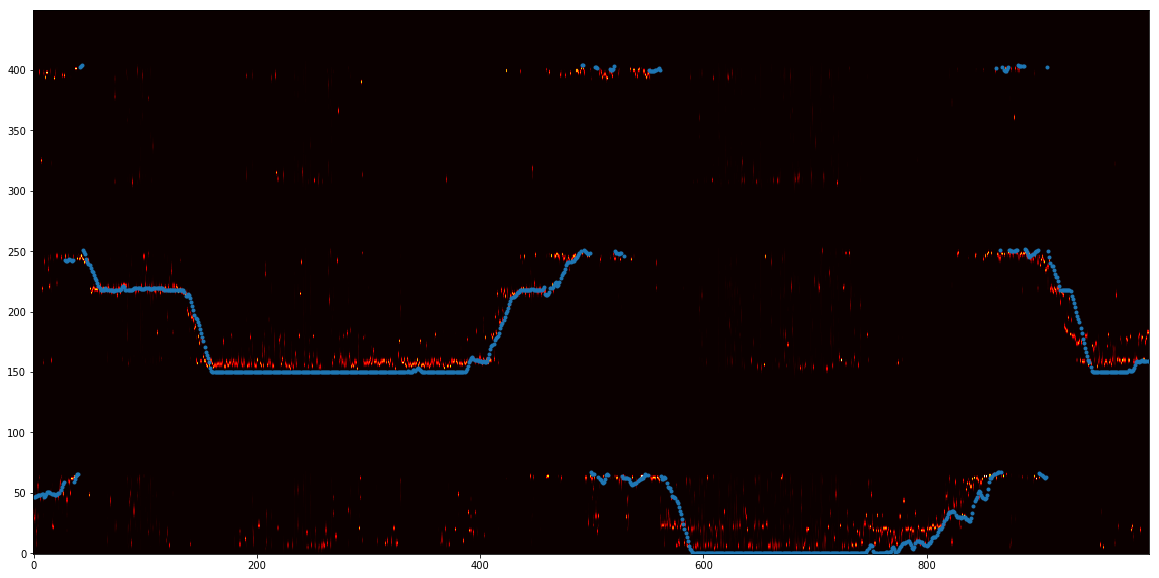

In [11]:
%matplotlib inline
plt.figure(figsize=[20,10])
plt.imshow(observ_binned.loc[:,'x000':'x449'][3000:4000].T, origin='lower', aspect='auto', cmap='hot', zorder=0)
plt.plot(single_axis_lin_pos.values[3000:4000], '.')
plt.show()